## Topic Modeling of PMC articles in the CORD-19 database




##### Topic Modeling
This is an unsupervised machine learning algorithm which reads into the words,phrases and semantic patterns of documents to unearth the hidden meaning of the texts by clustering word groups with similar patterns.
The draw back of this method is its unsupervised nature. That is the reason, many organizations prefer to train models and access their performance, rather than employing unsupervised models.

In this notebook, we’re going to delve into the 500 research articles and cluster them into groups to determine the nature of the articles.

In [1]:
#Loading The Libraries to form the df for the project
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import re
import gensim
import gensim.corpora as corpora
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
# topic modelling source:https://medium.com/@obianuju.c.okafor/automatic-topic-classification-of-research-papers-using-the-nlp-topic-model-nmf-
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GregFlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GregFlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df= pd.read_csv('capstone_data.csv')

In [3]:
df.head()

,cord_uid,title,pmcid,abstract,authors,journal,text_body
0,zowp10ts,Recombination Every Day: Abundant Recombinatio...,PMC1054884,Viral recombination can dramatically impact ev...,"Froissart, Remy; Roze, Denis; Uzest, Marilyne;...",PLoS Biol,Introduction\n\nAs increasing numbers of full-...
1,i4pmux28,Why can't I visit? The ethics of visitation re...,PMC1065028,"Patients want, need and expect that their rela...","Rogers, Sharon",Crit Care,Introduction\n\nThe sudden emergence of severe...
2,jw1lxwyd,Prospective evaluation of an internet-linked h...,PMC1065064,INTRODUCTION: Critical care physicians may ben...,"Lapinsky, Stephen E; Wax, Randy; Showalter, Ra...",Crit Care,Introduction\n\nThe rate of expansion of medic...
3,xiv9vxdp,Scanning the horizon: emerging hospital-wide t...,PMC1065120,This commentary represents a selective survey ...,"Suntharalingam, Ganesh; Cousins, Jonathan; Gat...",Crit Care,Introduction\n\nThis series of articles provid...
4,mcfmxqp2,Characterization of the frameshift signal of E...,PMC1065257,The ribosomal frameshifting signal of the mous...,"Manktelow, Emily; Shigemoto, Kazuhiro; Brierle...",Nucleic Acids Res,INTRODUCTION\n\nProgrammed −1 ribosomal frames...


In [4]:
#Remove the unecessary columns
df_mod=df[ ['pmcid','title','abstract','text_body']]
df_mod.head()

,pmcid,title,abstract,text_body
0,PMC1054884,Recombination Every Day: Abundant Recombinatio...,Viral recombination can dramatically impact ev...,Introduction\n\nAs increasing numbers of full-...
1,PMC1065028,Why can't I visit? The ethics of visitation re...,"Patients want, need and expect that their rela...",Introduction\n\nThe sudden emergence of severe...
2,PMC1065064,Prospective evaluation of an internet-linked h...,INTRODUCTION: Critical care physicians may ben...,Introduction\n\nThe rate of expansion of medic...
3,PMC1065120,Scanning the horizon: emerging hospital-wide t...,This commentary represents a selective survey ...,Introduction\n\nThis series of articles provid...
4,PMC1065257,Characterization of the frameshift signal of E...,The ribosomal frameshifting signal of the mous...,INTRODUCTION\n\nProgrammed −1 ribosomal frames...


In [5]:
#displaying the newly created df
df_mod.shape

(507, 4)

In [6]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pmcid      507 non-null    object
 1   title      507 non-null    object
 2   abstract   507 non-null    object
 3   text_body  507 non-null    object
dtypes: object(4)
memory usage: 16.0+ KB


In [7]:
#A little bit of superficial text cleaning to reduce the noise in the text

def clean_dataset(text):
    text=re.sub("[\[].*?[\]]", "", str(text))  #remove in-text citation
    text=re.sub(r'^https?:\/\/.*[\r\n]*', '',text, flags=re.MULTILINE)#remove hyperlink
    text=re.sub(r'^a1111111111 a1111111111 a1111111111 a1111111111 a1111111111.*[\r\n]*',' ',text)#some text has a11111.. 
    text=re.sub(r' +', ' ',text ) #remove extra space
    text=re.sub(r's/ ( *)/\1/g','',text)
    
    return text

In [8]:
# Apply the clean_data function to the abstract, text and title of the articles

df_mod['abstract'] =df_mod[['abstract','text_body']].apply(clean_dataset)

### Preprocess Data
Tokenize each sentence into a list of words, remove punctuations, remove stopwords and words of length less than 3, and then lemmatize.

In [9]:
#function for lemmatization
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

# tokenization
tokenized_data = df_mod['text_body'].apply(lambda x: x.split()) 

# Remove punctuation
tokenized_data = tokenized_data.apply(lambda x: [re.sub('[-,()\\!?]', '', item) for item in x])
tokenized_data = tokenized_data.apply(lambda x: [re.sub('[.]', ' ', item) for item in x])

#turn to lowercase
tokenized_data = tokenized_data.apply(lambda x: [item.lower() for item in x])

# remove stop-words and words of length less than 3
stop_words = stopwords.words('english')
stop_words.extend(['from','use', 'using','uses','user', 'users', 'well', 'study', 'survey', 'think'])
tokenized_data = tokenized_data.apply(lambda x: [item for item in x if item not in stop_words and len(item)>3])

#lemmatize by calling lemmatization function
tokenized_data= tokenized_data.apply(lambda x: [get_lemma(item) for item in x])

### Create Bigram and Trigram
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our corpus are: ‘visually_impaired’, ‘programming_language’, ‘block_based_programming’, 'programming environment' etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_data, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_data], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tokenized_data[0]]])

['introduction', 'increase_numbers', 'fulllength', 'viral', 'sequence', 'become_available', 'recombinant', 'mosaic_virus', 'recognize', 'frequently', '[123] ', 'recombination_event', 'demonstrate', 'associate', 'virus', 'expand', 'host_range', '[4567]', 'increase_virulence', '[89]', 'thus', 'accompany', 'perhaps', 'even', 'origin', 'major', 'change', 'virus', 'adaptation ', 'remains_unclear', 'however', 'whether', 'recombination_event', 'represent', 'highly', 'frequent', 'significant', 'phenomenon', 'everyday', 'life', 'viruses viruses', 'exchange', 'genetic_material', 'least', 'different', 'viral_genome', 'coinfect', 'host_cell ', 'progeny', 'become', 'hybrid', 'different', 'mechanism', 'reassortment', 'segment', 'parental', 'genome', 'fragment', '[10]', 'intramolecular', 'recombination', 'polymerase', 'switch', 'template', 'virus', '[11]', 'homologous_nonhomologous', 'recombination', 'viruses ', 'quantification', 'viral', 'recombination', 'multicellular', 'organism', 'attempt', 'dist

In [11]:
# Define functions for creating bigrams and trigrams.
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [12]:
# Form Bigrams
tokenized_data_bigrams = make_bigrams(tokenized_data)

 # Form Trigrams
tokenized_data_trigrams = make_trigrams(tokenized_data)

In [13]:
# de-tokenization, combine tokens together
detokenized_data = []
for i in range(len(df_mod)):
    t = ' '.join(tokenized_data_trigrams[i])
    detokenized_data.append(t)
    
df_mod['clean_text']= detokenized_data 
documents = df_mod['clean_text']

### Perform Exploratory Analysis
To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

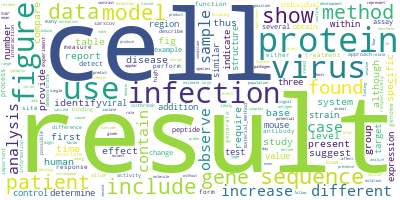

In [14]:

# Join the different processed titles together.
long_string = ','.join(list(documents.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Create Document-Term Matrix
This is the first step towards topic modeling. We need to represent each and every term and document as a vector.We will use sklearn's TfidfVectorizer to create a document-term matrix using only 1000 terms (words) from our corpus.

In [15]:
#Set variable number of terms 
no_terms = 1000

# NMF uses the tf-idf count vectorizer
# Initialise the count vectorizer with the English stop words
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, max_features=no_terms, stop_words='english')
# Fit and transform the text
document_matrix = vectorizer.fit_transform(documents)

#get features
feature_names = vectorizer.get_feature_names()

### Apply Topic Model
We will use the document-term matrix and decompose it into multiple matrices. We will use sklearn's NMF to perform the task of matrix decomposition. The number of topics can be specified by using the n_components parameter.

In [16]:
#Set variables umber of topics and top words.
no_topics = 10
no_top_words = 10

# Function for displaying topics
def display_topic(model, feature_names, num_topics, no_top_words, model_name):    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    print("Model Result:")
    word_dict = {};
    for i in range(num_topics):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-no_top_words - 1:-1]
        words = [feature_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i)] = words;
    dict = pd.DataFrame(word_dict);
    dict.to_csv('%s.csv' % model_name)
    return dict

In [17]:
# Apply NMF topic model to document-term matrix
nmf_model = NMF(n_components=no_topics, random_state=42, alpha=.1, l1_ratio=.5, init='nndsvd').fit(document_matrix)
#display topics for nmf model
display_topic(nmf_model, feature_names, no_topics, no_top_words, 'NMF_Model_Result')

Model Result:


,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,fig,health,mouse,patient,peptide,sarscov,genome,outbreak,frameshifting,probe
1,binding,public_health,lung,ards,epitope,sars,primer,epidemic,pseudoknot,array
2,mutant,information,fig,patients,binding,ace2,species,estimate,stem,microarray
3,receptor,country,vaccine,child,residue,sarscov_infection,strain,transmission,ribosome,microarrays
4,residue,access,antibody,sars,prediction,sars_patient,database,parameter,mrna,hybridization
5,domain,public,response,sars_patient,position,lung,alignment,assume,loop,detection
6,membrane,global,expression,pneumonia,amino_acid,serum,nucleotide,contact,structure,nucleic_acid
7,fusion,hospital,animal,treatment,predict,animal,annotation,distribution,codon,chip
8,interaction,participant,antigen,clinical,antigen,genotype,template,influenza,signal,signal
9,expression,response,mice,hospital,antibody,infect,cluster,intervention,translation,chips


The top ten topics‘are displayed below.
* Topic 03 is about covid patients.<br>
we can infer that patients are hospitalized because of sars(covid is a form of sars)and patients have pneumonia-an infection in their lungs.
* All of the 500 papers in the dataset falls under one of these 10 topics areas. 
Thus, I can use topic modelling to effectively classify the papers based on the content in them, rather thatn the title.
This will minimize errors due to my laziness and prevent judging a book by its cover.i.e reducing bias.
The generated topics thus classify every paper in the corpus.

### Analyzing our NMF model
To analyze the model, we visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which generates an inter-topic distance map. This map is designed to help in the understanding and interpreting of individual topics, and understanding the relationships between the topics. The closer the distance between topics and the more the overlap between topics the worse the performance of the model.

Looking at the plot below we can see that for the most part NMF produced topics that had good distance and no overlaps, this means that NMF produces distinctive topics.

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = sklearn_lda.prepare(nmf_model, document_matrix, vectorizer)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.056170 -0.036638       1        1  21.076544
6      0.003038 -0.131447       2        1  16.540339
2      0.072560  0.100378       3        1  14.811724
1      0.231699 -0.124869       4        1  13.224317
3      0.230014  0.037744       5        1  11.200962
7      0.194474 -0.105696       6        1   7.834494
9     -0.168117 -0.183823       7        1   4.434408
5      0.036722  0.398529       8        1   4.412289
4     -0.226356  0.009717       9        1   4.134021
8     -0.317865  0.036103      10        1   2.330903, topic_info=           Term       Freq      Total Category  logprob  loglift
806     sarscov  50.000000  50.000000  Default  30.0000  30.0000
652     peptide  41.000000  41.000000  Default  29.0000  29.0000
804        sars  34.000000  34.000000  Default  28.0000  28.0000
699       probe  24.000000  24.000000  Default  27.0000  27.0000
647     patient  38.000000  38.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
848        site   0.979535  11.123225  Topic10  -4.6129   1.3292
703     product   0.695927   7.060176  Topic10  -4.9547   1.4419
684     predict   0.913991  12.279761  Topic10  -4.6821   1.1610
357  expression   0.988386  15.774210  Topic10  -4.6039   0.9889
678    position   0.750527  10.525564  Topic10  -4.8792   1.1181

[466 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
10        1  0.881222   1993
11        1  0.896605   1994
12        1  0.978881   1995
13        1  0.992824   1996
14        1  0.914609   1997
...     ...       ...    ...
996       4  0.333045  years
996       5  0.499568  years
996       6  0.166523  years
997       1  0.647074  yeast
997      10  0.215691  yeast

[833 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 3, 2, 4, 8, 10, 6, 5, 9])

### Classify papers under topics
Using the 10 topics generated by our NMF model, we categorize each paper in our corpus under one of the 10 topics.

In [20]:
#Use NMF model to assign topic to papers in corpus
nmf_topic_values = nmf_model.transform(document_matrix)
df_mod['NMF Topic'] = nmf_topic_values.argmax(axis=1)

#Save dataframe to csv file
df_mod.to_csv('final_results.csv')
df_mod.head(10)

,pmcid,title,abstract,text_body,clean_text,NMF Topic
0,PMC1054884,Recombination Every Day: Abundant Recombinatio...,NaN,Introduction\n\nAs increasing numbers of full-...,introduction increase_numbers fulllength viral...,6
1,PMC1065028,Why can't I visit? The ethics of visitation re...,NaN,Introduction\n\nThe sudden emergence of severe...,introduction sudden emergence severe_acute_res...,1
2,PMC1065064,Prospective evaluation of an internet-linked h...,NaN,Introduction\n\nThe rate of expansion of medic...,introduction rate expansion medical knowledge ...,1
3,PMC1065120,Scanning the horizon: emerging hospital-wide t...,NaN,Introduction\n\nThis series of articles provid...,introduction series article provide regular su...,1
4,PMC1065257,Characterization of the frameshift signal of E...,NaN,INTRODUCTION\n\nProgrammed −1 ribosomal frames...,introduction program_ribosomal_frameshifting h...,8
5,PMC1072802,Torsional restraint: a new twist on frameshift...,NaN,INTRODUCTION\n\nThe structure of an RNA molecu...,introduction structure molecule widely recogni...,8
6,PMC1072806,Correcting errors in synthetic DNA through con...,NaN,INTRODUCTION\n\nMethods for the automated chem...,introduction method automate chemical_synthesi...,6
7,PMC1072807,Towards standardization of RNA quality assessm...,NaN,INTRODUCTION\n\nPurity and integrity of RNA ar...,introduction purity integrity critical element...,6
8,PMC1074505,Management of Critically Ill Patients with Sev...,NaN,"1. Introduction\n\nIn 2003, an outbreak of sev...",introduction 2003_outbreak severe_acute_respir...,3
9,PMC1074749,Species-independent detection of RNA virus by ...,NaN,INTRODUCTION\n\nIdentifying the causative agen...,introduction identify_causative_agent infectio...,6
